In [440]:
import struct
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
import const


In [448]:
format_string = '5i9d'
event_size = struct.calcsize(format_string)

with open('../data.bin.1', 'rb') as file:
    data_raw = file.read()

num_event = len(data_raw) // event_size
data = SimpleNamespace(
    id=[],
    nstep=[],
    Zelem=[],
    interaction=[],
    ion=[],
    time=[],
    x=[],
    y=[],
    z=[],
    ener=[],
    cos_th=[],
    ener_loss=[],
    ener_sec=[],
    ener_loss_sync=[]
)

for i in range(num_event):
    
    event_data = data_raw[i*event_size:(i+1)*event_size]
    event = struct.unpack(format_string, event_data)
    for i, key in enumerate(data.__dict__.keys()):
        getattr(data, key).append(event[i])

for i, key in enumerate(data.__dict__.keys()):
    setattr(data, key, np.array(getattr(data, key)))
    

In [450]:
def plot_traj(data, id, var_c=None, unit_l=const.AU, unit_c=const.day, cbar_label=r'$t$ [${\rm day}$]', cmap='jet', cval=0., do_top=False):
    
    ax = plt.figure().add_subplot(projection='3d')
    
    cond = (data.id == id)
    
    nstep = np.max(data.nstep[cond]+1)
    nseg = min(nstep, 256)
    skip = int(nstep/nseg)

    if type(var_c) == type(None): var_c = data.time
    cmin = min(cval/unit_c, var_c[cond][-1]/unit_c)
    cmax = max(cval/unit_c, var_c[cond][-1]/unit_c)
    norm = Normalize(cmin, cmax)
    color_list = mpl.colormaps[cmap](norm(var_c[cond][::skip]/unit_c))
    
    ax.plot([0], [0], [0], color='black', marker='o')
    ax.plot([0, data.x[cond][0]/unit_l], [0, data.y[cond][0]/unit_l], [0, data.z[cond][0]/unit_l], color=color_list[0], lw=2)
    for i in range(nseg):
        ax.plot(data.x[cond][i*skip:(i+1)*skip+1]/unit_l, data.y[cond][i*skip:(i+1)*skip+1]/unit_l, data.z[cond][i*skip:(i+1)*skip+1]/unit_l, color=color_list[i], lw=2)

    sm = ScalarMappable(norm, cmap=cmap)
    cax = ax.inset_axes([1.1, 0, 0.075, 1])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label(cbar_label, fontsize=14)
    
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$ [AU]', fontsize=14)
    ax.set_ylabel(r'$y$ [AU]', fontsize=14)
    ax.set_zlabel(r'$z$ [AU]', fontsize=14)
    
    if do_top:
        axtop = ax.inset_axes([0, 1.1, 1.1, 0.5])
        axtop.plot(data.time[cond], var_c[cond]/unit_c, lw=2)
        axtop.set_xlabel(r'$t$ [${\rm s}$]', fontsize=14)
        axtop.set_ylabel(cbar_label, fontsize=14)
    

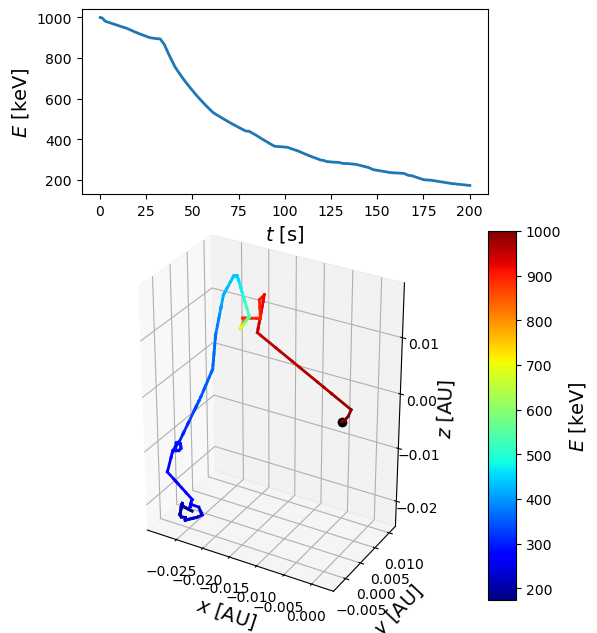

In [452]:
#plot_traj(data, 0, var_c=data.time, unit_c=1., cbar_label=r'$t$ [${\rm s}$]', cval=0, do_top=False)
plot_traj(data, 9, var_c=data.ener, unit_c=1e3, cbar_label=r'$E$ [${\rm keV}$]', cval=1000000, do_top=True)
